# Model performance report for the EfficientNet-ResidualMLP training run on the night of 2021-12-15_2021_12_16 (run b)

### (Note the code for this run is the last commit. The code showing in this commit is ammended 
### for tonight's run.)

Hyperparameters:

## Model archirtecture:

Base model: Tandem EfficientNetB7 -> Residual Multi Layer Perceptron:

## EfficientNetB7 architecture:

1. Standard EfficientNetB7 with weights from ImageNet


## Residual Multi Layer Perceptron sub-model Architecture:

Each nested list is a residual block that chains together: 
(left side, input side, right side output side of the residual blocks pertion of the network):

```python
{
    [[5,150,10],[5,75,10],[5,75,10],[5,75,10],[5,75,10],[5,75,10]]
}
```

1. Explained:
    1. The integer on the 0th index is the number of layers in the block. 
    2. The integer on the 1st index is the number Dense layer neurons on the *first* layer of 
       the block.
    3. The integer in the 2nd index is a "subtractive decay factor". Each successive layer
       will have n fewer neurons than the last layer. If you want all layers the same,
       select 0 for this hyperparameter. You must exercise care not to call invalid permutations 
       of x[1] and x[2] (especially if you wite a script to recursively build models, 
       for example, neural architecture search applications). It is obvious we can't build 
       a model with a negatve number of neurons, and making x[2] too high, given x[0] 
       (number of layers) and x[1] (neurons in the first layer) will result in a negative 
       number for Dense units for some layers. This should throw an exception if this happens. 
       Monitor the logs of your training runs so as to detect any such issue.
    3. Each block will consist of the Dense layers that the architecture scripting algorithym 
       described above, in a sequential arrangement. The input of each block will split into 2 identical 
       tensors 'x' and 'y'.  The tensor 'x' is batch bormalized and fed through the block of Dense 
       layers. The tensor y is fed in parallel through a single batch normalization layer  
       and will bypass the block of Dense layers. At the end of the block, the 2 tensors x and y are 
       concatenated and will be batch normalized and passed to the downstream blocks / layers.
       
A general property of this residual MLP architecture is that it appears to typically allow 
about 7 X the total model complexity and up to ~ 30 X as deep of a network before it 
significantly overfits [or creates other problems that tend to be model complexity limiting factors] 
when compared to a sequential Multi Layer Perceptron. It also appears to allow great performance 
from much smaller training sets. In this model, all inputs to Dense layers (except the first)
were batch normalized. Relu actiation and GlorotNormal initialization was used for all Dense 
layers.

## Additional Hyperparameters:

optimizer: Adam - learning_rate .0007, clip_norm = 1.0

loss: CategoricalCrossentropy

Final 3 dense layers following the residual mlp blocks: (each followed by batch norm): 

100 units,35 units, 21 units 

56 epochs

Early stopping callback: monitor val_loss, patence 50 (basically run all 56, 
but use this callback to leverage "restore_best_weights" so if the 54th epoch persorms best,
it retunrs this as the final mode.)

Model training set:

5000 randomly selected ciphar10 training set images (1/10 of the usual training set).

In [ ]:
## Below is a sample of how to use the residualmlp package to byild a transfer learning model ...

In [ ]:
! pip3 install pandas
! pip3 install seaborn
! pip3 install matplotlib

     |█▎                              | 450 kB 23.6 MB/s eta 0:00:01  Downloading pandas-1.3.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
     |████████████████████████████████| 11.5 MB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 23.6 MB/s 
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 292 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 24.1 MB/s eta 0:00:01
     |█▊                              | 614 kB 24.6 MB/s eta 0:00:01Collecting matplotlib>=2.2
     |████████████████████████████████| 11.3 MB 24.6 MB/s eta 0:00:01    |██████████▊                     | 3.8 MB 24.6 MB/s eta 0:00:01     |██████████▊                     | 3.8 MB 24.6 MB/s eta 0:00:01     |█████████████████▍              | 6.1 MB 24.6 MB/s eta 0:00:01     |██████████

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
# get our data

cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar



170508288/170498071 [==============================] - 42s 0us/step


In [ ]:
# Another random set of 5000
TRAINING_SET_SIZE = 5000
y_train_ohe = tf.one_hot([i[0] for i in  y_train],10)
indexes_for_rows = tf.range(0,y_train.shape[0])
shuffled_indexes = tf.random.shuffle(indexes_for_rows)
selected_indexes = shuffled_indexes[:TRAINING_SET_SIZE]
selected_x_train = x_train[selected_indexes,:,:,:]
selected_y_train_ohe = y_train_ohe.numpy()[selected_indexes,:]

In [ ]:
# find our history fromlast night's run:
!ls

2021-12-15_02_00_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.csv
2021-12-15_02_00_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.json
Untitled.ipynb
2021-12-15_02_00_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.csv
2021-12-15_02_00_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.json
Untitled.ipynb


In [ ]:
history = pd.read_csv('2021-12-15_02_00_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.csv')

In [ ]:
history.columns

Index(['Unnamed: 0', 'loss', 'precision', 'recall', 'accuracy', 'val_loss',
       'val_precision', 'val_recall', 'val_accuracy'],
      dtype='object')

Index(['Unnamed: 0', 'loss', 'precision', 'recall', 'accuracy', 'val_loss',
       'val_precision', 'val_recall', 'val_accuracy'],
      dtype='object')

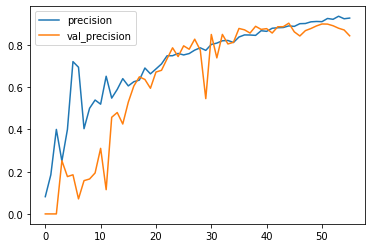

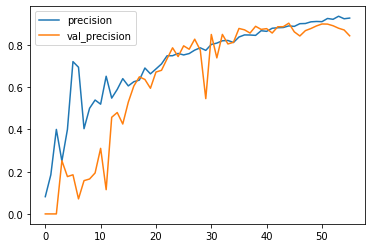

In [ ]:
# Plot val precision vs train precision:
history[['precision','val_precision']].plot()
plt.show()

<AxesSubplot:>

<AxesSubplot:>

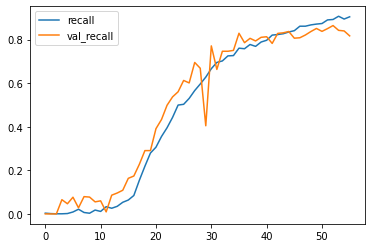

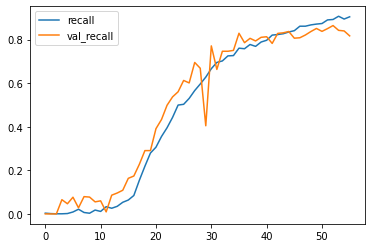

In [ ]:
history[['recall','val_recall']].plot()

In [ ]:
# Slight overfitting ... but 84.5% test recall form only 10% of the training set. Not a bad start...


In [7]:
# 2021-12-18: Redid the experiment, this time setting all layers in the EfficientNte base model as trainable=False.

# Results in next cells:
!pip3 install pandas
import pandas as pd
!pip3 install matplotlib
import matplotlib.pyplot as plt


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.3 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 885 kB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 25.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 24.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [9]:
all_tx_false_history = pd.read_csv('2021-12-18_17_15_exported_model_lr10e-3_bl5_7fl5_flaten_bnorm-history.csv')
all_tx_false_history.columns

Index(['Unnamed: 0', 'loss', 'precision', 'recall', 'accuracy',
       'top_5_categorical_accuracy', 'top_4_categorical_accuracy',
       'top_3_categorical_accuracy', 'top_2_categorical_accuracy',
       'top_1_categorical_accuracy', 'val_loss', 'val_precision', 'val_recall',
       'val_accuracy', 'val_top_5_categorical_accuracy',
       'val_top_4_categorical_accuracy', 'val_top_3_categorical_accuracy',
       'val_top_2_categorical_accuracy', 'val_top_1_categorical_accuracy'],
      dtype='object')

<AxesSubplot:>

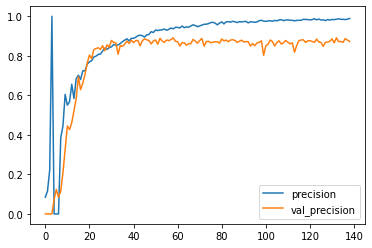

In [8]:
all_tx_false_history[['precision','val_precision',]].plot()

In [ ]:
# This performed well on precision. Converging at ~ 40 epochs at ~ 85%

<AxesSubplot:>

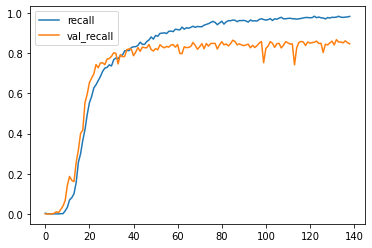

In [10]:
all_tx_false_history[['recall','val_recall']].plot()

In [11]:
# This did not perform as well on recall. 
# Next steps: try setting all convo layers in the last bloxk to trainable and include preporcessing.

In [ ]:
label_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

In [ ]:
### Reserved for future tests ...

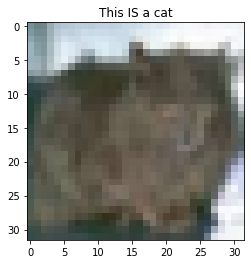

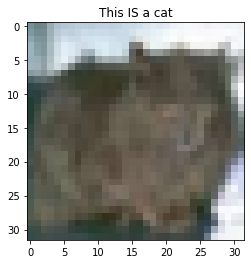

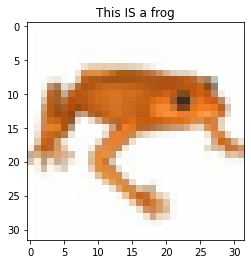

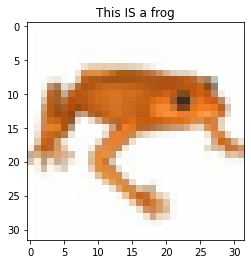

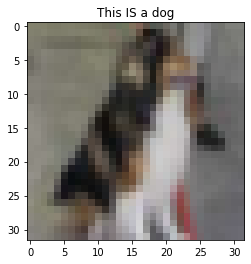

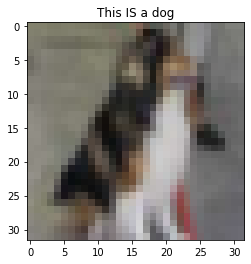

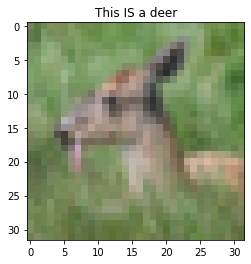

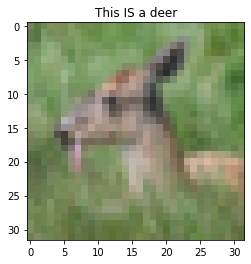

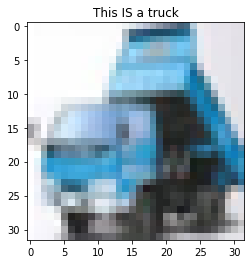

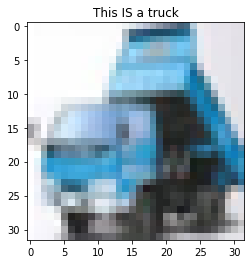

In [ ]:
sanity_check_subset_x = selected_x_train[:5]
sanity_check_subset_y = selected_y_train_ohe[:5]

for i in np.arange(5):
    plt.imshow(sanity_check_subset_x[i])
    plt.title(f"This IS a {label_names[np.argmax(sanity_check_subset_y[i])]}")
    plt.show()

